In [8]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant



#### --------- Definition of variables ------------------------

N_size=5001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

In [9]:
n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))

interactive_plot = interactive(plot_interactive, beta=gap_temp, mu=0)
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

interactive(children=(FloatSlider(value=0.4082482938630433, description='beta', max=1.22474488158913, min=-0.4…

In [10]:
x=np.arange(0,(N_size-1)/2+ 1)
beta=gap_temp
mu=0
m_cos=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
m_sin=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
m_cos=np.array(m_cos[1:][::-1]+m_cos)
m_sin=np.array(m_sin[1:][::-1]+m_sin)
M_plus=(m_cos+m_sin)*0.5
M_minous=(m_cos-m_sin)*0.5
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mplusband=M_plus*np.array(Mplusband)
Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mminousband=M_minous*np.array(Mminousband)
Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
Fourier_minous=fftshift(fft(ifftshift(Mminousband)))

In [11]:
def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

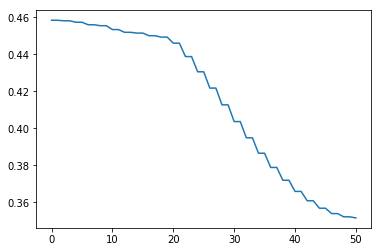

In [12]:
L=51
n=np.arange(-(L-1)/2,(L-1)/2 +1)
plt.plot(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True))

# Test ground state

In [15]:
x=np.arange(0,(N_size-1)/2+ 1)
m_cos=[-0.5 for i in x]
m_sin=[-0.5 for i in x]
m_cos=np.array(m_cos[1:][::-1]+m_cos)
m_sin=np.array(m_sin[1:][::-1]+m_sin)
M_plus=(m_cos+m_sin)*0.5
M_minous=(m_cos-m_sin)*0.5
x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mplusband=M_plus*np.array(Mplusband)
Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
Mminousband=M_minous*np.array(Mminousband)
Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
Cov_matrix=(Create_anti_circulant(Fourier_minous)+Create_circulant(Fourier_plus))*1/N_size

In [16]:
result=[]
for i in range(5, 50):
    New_Cov_matrix=Take_portion(Cov_matrix,i)
    A,S,B=np.linalg.svd(New_Cov_matrix)
    aux=np.sum(Binary_entropy((S+0.5))) #Binary entropy does not work
    result.append(aux)

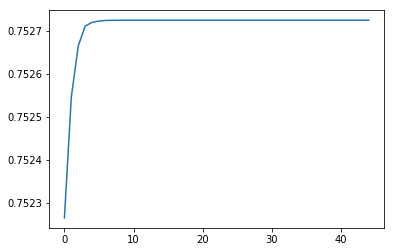

In [17]:
plt.plot(result)

### Now it is working, the entropy of the ground state seems to be the one that corresponds to the theoretical behaviour of area law!!

# random generic state

In [86]:
def Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
        m_sin=[0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else -0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
    Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
    return Fourier_plus,Fourier_minous

def Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size):
    F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size)
    return F_plus[(N_size-1)//2-L//2:(N_size-1)//2+L//2+1], F_minous[(N_size-1)//2-L//2:(N_size-1)//2+L//2+1]
def Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size):
    circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size)
    return (Create_circulant(circulant)+Create_anti_circulant(anticirculant))/N_size

In [87]:
L=500
N_size=50001 #
Gamma=0.5
Lambda=0.5
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
A,S,B=np.linalg.svd(Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size))

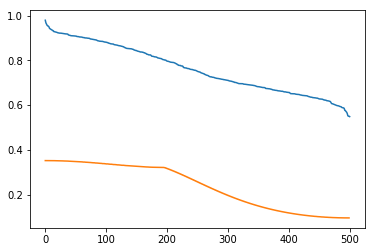

In [94]:
plt.plot(S+0.5,label="Singular values")
n=np.arange(-(L-1)/2,(L-1)/2 +1)
plt.plot(np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)),label="Fermi distribution")

In [39]:
sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)

[0.35155124464983856,
 0.35155124464983856,
 0.3515473127395579,
 0.3515473127395579,
 0.3515008946500685,
 0.3515008946500685,
 0.35148724876460324,
 0.35148724876460324,
 0.3513981995166208,
 0.3513981995166208,
 0.3513692992822304,
 0.3513692992822304,
 0.35124517236106423,
 0.35124517236106423,
 0.3511918173292823,
 0.3511918173292823,
 0.3510438922691817,
 0.3510438922691817,
 0.35095327174023067,
 0.35095327174023067,
 0.35079649398113855,
 0.35079649398113855,
 0.3506522558900362,
 0.3506522558900362,
 0.35050515771991264,
 0.35050515771991264,
 0.350287495741165,
 0.350287495741165,
 0.35017209926501774,
 0.35017209926501774,
 0.3498578570820846,
 0.3498578570820846,
 0.3497995603572829,
 0.3497995603572829,
 0.34938979950843324,
 0.34938979950843324,
 0.34936235185556663,
 0.34936235185556663,
 0.348945083276847,
 0.348945083276847,
 0.3488001434889109,
 0.3488001434889109,
 0.3484676780585254,
 0.3484676780585254,
 0.3481705511544042,
 0.3481705511544042,
 0.3479598424303023,